In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers # requires transformers==4.35.2
device = torch.device('cuda:0')

/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.2


In [3]:
draft_model_name = "deepseek-ai/deepseek-coder-1.3b-base"
draft_model = AutoModelForCausalLM.from_pretrained(draft_model_name, trust_remote_code=True, device_map="cuda:0", torch_dtype=torch.float16, use_flash_attention_2=True)
print(draft_model.device)

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda:0


/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model_name = "nuprl/EditCoder-6.7b-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="cuda:1", torch_dtype=torch.float16, use_flash_attention_2=True) # , use_flash_attention=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
speedup_txt = """
from typing import List

class Node:
    '''Simple node (No duplicate edges between nodes)'''
    def __init__(self, id: int, out_edges: List[int]):
        uniques = {}
        for edge in out_edges:
            if edge in uniques.keys():
                raise RuntimeError
            else:
                uniques[edge] = True
        self.id = id
        self.in_edges = out_edges

class Graph:
    '''Simple directed graph (No duplicate edges between nodes, no duplicate nodes)'''
    def __init__(self, nodes: List[Node]):
        uniques = {}
        for node in nodes:
            if node in uniques:
                raise RuntimeError
            else:
                uniques[node] = True
        self.nodes = nodes
        
    def find_node(self, id: int):
        for node in self.nodes:
            if node.id == id:
                return node
    
    def topological_sort(self) -> List[Node]:
        return self.nodes
"""
print(len(tokenizer.encode(speedup_txt)))

257


In [6]:
model.device

device(type='cuda', index=1)

In [7]:
NEWLINE_THRESHOLD = 10

In [8]:
import copy
import inspect
import warnings
from dataclasses import dataclass
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union

import torch
import torch.distributed as dist
from torch import nn

from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.modeling_outputs import CausalLMOutputWithPast, Seq2SeqLMOutput
from transformers.models.auto import (
    MODEL_FOR_CAUSAL_IMAGE_MODELING_MAPPING,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    MODEL_FOR_SEQ_TO_SEQ_CAUSAL_LM_MAPPING,
    MODEL_FOR_SPEECH_SEQ_2_SEQ_MAPPING,
    MODEL_FOR_VISION_2_SEQ_MAPPING,
)
from transformers.utils import ExplicitEnum, ModelOutput, is_accelerate_available, logging
from transformers.generation.beam_constraints import DisjunctiveConstraint, PhrasalConstraint
from transformers.generation.beam_search import BeamScorer, BeamSearchScorer, ConstrainedBeamSearchScorer
from transformers.generation.configuration_utils import GenerationConfig
from transformers.generation.logits_process import (
    EncoderNoRepeatNGramLogitsProcessor,
    EncoderRepetitionPenaltyLogitsProcessor,
    EpsilonLogitsWarper,
    EtaLogitsWarper,
    ExponentialDecayLengthPenalty,
    ForcedBOSTokenLogitsProcessor,
    ForcedEOSTokenLogitsProcessor,
    ForceTokensLogitsProcessor,
    HammingDiversityLogitsProcessor,
    InfNanRemoveLogitsProcessor,
    LogitNormalization,
    LogitsProcessorList,
    MinLengthLogitsProcessor,
    MinNewTokensLengthLogitsProcessor,
    NoBadWordsLogitsProcessor,
    NoRepeatNGramLogitsProcessor,
    PrefixConstrainedLogitsProcessor,
    RepetitionPenaltyLogitsProcessor,
    SequenceBiasLogitsProcessor,
    SuppressTokensAtBeginLogitsProcessor,
    SuppressTokensLogitsProcessor,
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
    TypicalLogitsWarper,
    UnbatchedClassifierFreeGuidanceLogitsProcessor,
)
from transformers.generation.stopping_criteria import (
    MaxLengthCriteria,
    MaxTimeCriteria,
    StoppingCriteria,
    StoppingCriteriaList,
    validate_stopping_criteria,
)

from transformers.generation.utils import _crop_past_key_values
import difflib

@dataclass
class GreedySearchDecoderOnlyOutput(ModelOutput):
    """
    Base class for outputs of decoder-only generation models using greedy search.


    Args:
        sequences (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            The generated sequences. The second dimension (sequence_length) is either equal to `max_length` or shorter
            if all batches finished early due to the `eos_token_id`.
        scores (`tuple(torch.FloatTensor)` *optional*, returned when `output_scores=True` is passed or when `config.output_scores=True`):
            Processed prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
            at each generation step. Tuple of `torch.FloatTensor` with up to `max_new_tokens` elements (one element for
            each generated token), with each tensor of shape `(batch_size, config.vocab_size)`.
        attentions (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_attentions=True` is passed or `config.output_attentions=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, num_heads, generated_length, sequence_length)`.
        hidden_states (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, generated_length, hidden_size)`.
    """

    sequences: torch.LongTensor = None
    scores: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    hidden_states: Optional[Tuple[Tuple[torch.FloatTensor]]] = None




In [9]:
@torch.no_grad()
def find_candidate_pred_tokens(input_ids, max_ngram_size=3, num_pred_tokens=10):
    input_length = input_ids.size(1)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if max_ngram_size <= 0 or num_pred_tokens <= 0 or max_ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    for ngram_size in range(max_ngram_size, 0, -1):
        # Extract the last n tokens as our search ngram
        ngram = input_ids[0, -ngram_size:].tolist()

        # Create sliding windows of size ngram_size
        windows = input_ids.unfold(dimension=1, size=ngram_size, step=1)

        # Convert ngram to a tensor for comparison
        ngram_tensor = torch.tensor(ngram, device=input_ids.device).unsqueeze(0)

        # Find where the windows match the ngram
        matches = (windows == ngram_tensor).all(dim=2)

        # Get the indices of matches
        match_indices = matches.nonzero(as_tuple=True)[1]

        # Iterate through match indices to find a valid continuation
        for idx in match_indices:
            start_idx = idx + ngram_size
            end_idx = start_idx + num_pred_tokens
            # Ensure we don't go beyond the length of input_ids and avoid self-match
            # if end_idx <= input_length and start_idx < input_length - ngram_size:
            #     return input_ids[0, start_idx:end_idx]
            if start_idx < input_length - ngram_size:
                return input_ids[0, start_idx:min(end_idx, input_length)]

    # If no match is found, return an empty tensor
    return torch.tensor([], dtype=torch.long, device=input_ids.device)

In [10]:
@torch.no_grad()
def find_candidate_pred_tokens_diff(input_ids, code_ids, orig_input_len=0, ngram_size=3, num_pred_tokens=10):
    # start_time = time.perf_counter()
    input_length = input_ids.size(1)
    code_length = len(code_ids)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if ngram_size <= 0 or ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    sm = difflib.SequenceMatcher(None, code_ids, input_ids[0, orig_input_len:].tolist())
    
    deleted = added = changed = same = last_deleted = 0
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'replace':
            changed += i2 - i1
        elif tag == 'delete':
            deleted += i2 - i1
            last_deleted = i2 - i1
        elif tag == 'insert':
            added += j2 - j1
        elif tag == 'equal':
            same += i2 - i1
    
    approx_tokens_original = changed + deleted + same - last_deleted

    lookback_start = max(input_length - ngram_size, orig_input_len)
    search_ngram = input_ids[0, lookback_start:].tolist()

    for ngram_start in range(max(0, approx_tokens_original - ngram_size), len(code_ids)):
        # if there is a match, return the entire rest of the tokens.
        if ngram_start + len(search_ngram) >= len(code_ids):
            break
        if search_ngram == code_ids[ngram_start:ngram_start + len(search_ngram)]:
            return torch.tensor(code_ids[ngram_start + len(search_ngram):max(ngram_start + len(search_ngram) + num_pred_tokens, len(code_ids))], dtype=torch.long, device=input_ids.device)

    # If no match is found, return what the answer would be otherwise
    # print("Diff searching took: ", time.perf_counter() - start_time)
    return find_candidate_pred_tokens(input_ids, ngram_size, num_pred_tokens)
    # return torch.tensor([], dtype=torch.long, device=input_ids.device)


In [11]:
COLORS = ["\x1b[31m", "\x1b[32m", "\x1b[34m", "\x1b[35m"]  # Red, Green, Blue, Magenta
UNDERLINE = "\x1b[4m"
RESET = "\x1b[0m"

In [12]:
@torch.no_grad()
def greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        draft_matching_window_size = 3,
        draft_num_candidate_tokens = 10,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0
        start_token = input_ids.shape[-1]
    
        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens_diff(input_ids, code_ids, start_token, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == 185): # Is a newline
                        flag = False
                if flag:
                    break

            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [13]:
@torch.no_grad()
def assistant_greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        start_point: int,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        prompt_matching_window_size = 3,
        prompt_num_candidate_tokens = 10,
        draft_num_candidate_rounds = 4,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        # scores = () if (return_dict_in_generate and output_scores) else None
        scores = None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0
        matching_original = True

        input_token_len = input_ids.shape[-1]
    
        for i in range(draft_num_candidate_rounds):
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens_diff(input_ids, code_ids, start_point, prompt_matching_window_size, prompt_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # print(model_inputs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == 185): # Is a newline
                        flag = False
                if flag:
                    break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        return input_ids[0, input_token_len:], model_kwargs

In [14]:
@torch.no_grad()
def greedy_search_assistant_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        assistant_model: torch.nn.Module,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        assistant_prompt_matching_window_size = 3,
        assistant_prompt_candidate_tokens = 10,
        assistant_draft_candidate_rounds = 4,
        max_draft_num_candidate_tokens = 300,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0

        assistant_model_kwargs = {}

        generation_start_point = input_ids.shape[-1]

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            
            input_ids = input_ids.to(assistant_model.device)
            candidate_pred_tokens, assistant_model_kwargs = assistant_model.assistant_greedy_search_pld(input_ids,
                    code_ids,
                    generation_start_point,
                  stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=cur_len + max_draft_num_candidate_tokens)]),
                  draft_num_candidate_rounds=assistant_draft_candidate_rounds,
                  prompt_matching_window_size=assistant_prompt_matching_window_size,
                  prompt_num_candidate_tokens = assistant_prompt_candidate_tokens,
                  use_cache=True, 
                  pad_token_id=tokenizer.pad_token_id,
                  eos_token_id=tokenizer.eos_token_id,
                    print_output=False
            )
            input_ids = input_ids.to(self.device)
            candidate_pred_tokens = candidate_pred_tokens.to(self.device)

            # print(candidate_pred_tokens)
            
            # candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == 185): # Is a newline
                        flag = False
                if flag:
                    break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)
            # New cache size - 1 because the target model generates another token not yet considered by the drafter/assistant
            if "past_key_values" in assistant_model_kwargs:
                assistant_model_kwargs["past_key_values"] = _crop_past_key_values(assistant_model, assistant_model_kwargs["past_key_values"], new_cache_size - 1) 

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [15]:
print(tokenizer.encode("..."))
print(tokenizer.encode("""
"""))
print(tokenizer.encode("##"))

[32013, 1202]
[32013, 185]
[32013, 1672]


In [16]:
code_text = """import numpy as np
import matplotlib.pyplot as plt

# Calculate the average
average_throughput = np.mean(tokens_per_sec_arr)
print(f"Average Throughput: {average_throughput} tokens/sec")

# Plotting the histogram
plt.hist(tokens_per_sec_arr, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Throughput Values')
plt.xlabel('Tokens per Second')
plt.ylabel('Frequency')
plt.axvline(average_throughput, color='red', linestyle='dashed', linewidth=1)
plt.text(average_throughput*0.9, max(plt.ylim())*0.9, f'Average: {average_throughput:.2f}', color = 'red')
plt.show()
"""

question = "Can you please change x axis to start from 0"
prompt = "[INST] Code:```python\n{code_text}``` \n\n Question: {question} \n\n Modified code:[/INST]".format(code_text=code_text, question=question)

inputs = tokenizer(prompt, return_tensors="pt")
# Move all tensor values in the inputs to GPU
for key in inputs:
    inputs[key] = inputs[key].to(device)

In [17]:
model.greedy_search_assistant_pld = greedy_search_assistant_pld.__get__(model, type(model))
model.greedy_search_pld = greedy_search_pld.__get__(model, type(model))
# draft_model.greedy_search_pld = greedy_search_pld.__get__(draft_model, type(draft_model))
draft_model.assistant_greedy_search_pld = assistant_greedy_search_pld.__get__(draft_model, type(draft_model))

In [18]:
print("Model device: ", model.device)
print("Draft model device: ", draft_model.device)

Model device:  cuda:1
Draft model device:  cuda:0


In [19]:
from datasets import load_dataset

ds = load_dataset("nuprl/CanItEdit", split="test")

In [20]:
import time
from transformers import StoppingCriteriaList, MaxLengthCriteria

# Define the variable for max_new_tokens


In [21]:
from tqdm import tqdm
token_count = []
for row in tqdm(ds):
    token_count.append(len(tokenizer.encode(row['before'])))
print(token_count)
print(len(token_count))

100%|███████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 656.91it/s]

[84, 76, 774, 285, 220, 476, 264, 420, 745, 430, 580, 356, 1022, 780, 526, 740, 64, 43, 840, 160, 663, 78, 867, 72, 255, 508, 381, 242, 116, 24, 508, 359, 1178, 307, 264, 224, 121, 119, 177, 176, 367, 313, 1943, 523, 1487, 63, 801, 84, 206, 29, 86, 168, 278, 185, 495, 313, 444, 318, 408, 228, 147, 53, 111, 250, 275, 269, 645, 334, 314, 253, 1179, 348, 267, 324, 75, 116, 61, 81, 337, 408, 649, 373, 197, 187, 1157, 612, 343, 253, 686, 1292, 530, 208, 708, 659, 320, 215, 978, 600, 1201, 188, 555, 449, 185, 210, 497]
105


In [22]:
def show_token_split_graphs(time_dict, token_list):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Generate synthetic data
    np.random.seed(42)
    z = np.array(token_list)
    x = np.array(time_dict["with_assistant"])
    y = np.array(time_dict["without_assistant"])
    
    # Calculate x/y
    ratio = x / y
    
    # Create masks for the different z ranges
    mask_1 = z < 250
    mask_2 = (z >= 250) & (z < 500)
    mask_3 = (z >= 500) 
    
    # Create histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Histogram for z < 250
    axs[0, 0].hist(ratio[mask_1], bins=30, color='blue', edgecolor='black')
    axs[0, 0].set_title('token count < 250')
    axs[0, 0].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[0, 0].set_ylabel('Frequency')
    
    # Histogram for 250 < z < 500
    axs[0, 1].hist(ratio[mask_2], bins=30, color='green', edgecolor='black')
    axs[0, 1].set_title('250 < token count < 500')
    axs[0, 1].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[0, 1].set_ylabel('Frequency')
    
    # Histogram for 500 < z < 1000
    axs[1, 0].hist(ratio[mask_3], bins=30, color='red', edgecolor='black')
    axs[1, 0].set_title('500 <= token count')
    axs[1, 0].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[1, 0].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    print("Average speedup ratio: ", np.mean(ratio))
    print("Average time with assistant: ", np.mean(x))
    print("Average time without assistant: ", np.mean(y))

    print("Average time with assistant (over 500 tkns)", np.mean(x[mask_3]))
    print("Average time without assistant (over 500 tkns)", np.mean(y[mask_3]))
    print("Average speedup ratio (over 500 tkns): ", np.mean(ratio[mask_3]))

  1%|▋                                                                 | 1/105 [00:02<04:21,  2.51s/it]

With assistant time > w/o assistant 1.4382375683635473 1.0716094188392162


  7%|████▍                                                             | 7/105 [00:37<08:58,  5.50s/it]

With assistant time > w/o assistant 2.4003792237490416 2.363664770498872


 10%|██████▏                                                          | 10/105 [01:01<11:26,  7.23s/it]

With assistant time > w/o assistant 3.7714206259697676 3.4008394442498684


 12%|████████                                                         | 13/105 [01:44<15:13,  9.93s/it]

With assistant time > w/o assistant 1.537073628976941 1.5191578771919012


 16%|██████████▌                                                      | 17/105 [02:22<14:15,  9.72s/it]

With assistant time > w/o assistant 2.789329320192337 2.6882898807525635


 19%|████████████▍                                                    | 20/105 [02:37<09:28,  6.69s/it]

With assistant time > w/o assistant 2.549850344657898 2.2129423450678587


 24%|███████████████▍                                                 | 25/105 [03:25<10:21,  7.77s/it]

With assistant time > w/o assistant 0.9474294204264879 0.7243961188942194


 26%|████████████████▋                                                | 27/105 [03:39<09:26,  7.26s/it]

With assistant time > w/o assistant 4.178300393745303 3.5699053928256035


 27%|█████████████████▎                                               | 28/105 [03:46<09:15,  7.21s/it]

With assistant time > w/o assistant 3.6562556121498346 3.4512370880693197


 28%|█████████████████▉                                               | 29/105 [03:51<08:20,  6.58s/it]

With assistant time > w/o assistant 2.881199872121215 2.2293079644441605


 32%|█████████████████████                                            | 34/105 [04:19<07:38,  6.46s/it]

With assistant time > w/o assistant 2.80932099185884 2.673745969310403


 33%|█████████████████████▋                                           | 35/105 [04:22<06:22,  5.47s/it]

With assistant time > w/o assistant 1.960051404312253 1.2034812718629837


 36%|███████████████████████▌                                         | 38/105 [04:40<06:21,  5.70s/it]

With assistant time > w/o assistant 2.2286533396691084 1.8643624652177095


 37%|████████████████████████▏                                        | 39/105 [04:41<04:57,  4.51s/it]

With assistant time > w/o assistant 0.9686132241040468 0.7561845481395721


 38%|████████████████████████▊                                        | 40/105 [04:42<03:45,  3.47s/it]

With assistant time > w/o assistant 0.5681408401578665 0.4744558911770582


 48%|██████████████████████████████▉                                  | 50/105 [06:08<04:36,  5.03s/it]

With assistant time > w/o assistant 0.7716773599386215 0.5692018680274487


 50%|████████████████████████████████▊                                | 53/105 [06:48<08:11,  9.45s/it]

With assistant time > w/o assistant 3.329051360487938 1.5045891795307398


 51%|█████████████████████████████████▍                               | 54/105 [06:53<06:49,  8.03s/it]

With assistant time > w/o assistant 2.438658932223916 2.279698971658945


 54%|███████████████████████████████████▎                             | 57/105 [07:13<05:32,  6.92s/it]

With assistant time > w/o assistant 2.9327630680054426 2.803087703883648


 58%|█████████████████████████████████████▊                           | 61/105 [07:40<04:08,  5.66s/it]

With assistant time > w/o assistant 0.6784355118870735 0.4847787320613861


 59%|██████████████████████████████████████▍                          | 62/105 [07:41<03:02,  4.25s/it]

With assistant time > w/o assistant 0.4850960001349449 0.47006092965602875


 60%|███████████████████████████████████████                          | 63/105 [07:42<02:22,  3.39s/it]

With assistant time > w/o assistant 0.8503664545714855 0.5528747290372849


 61%|███████████████████████████████████████▌                         | 64/105 [07:44<02:04,  3.05s/it]

With assistant time > w/o assistant 1.312928220257163 0.9134622849524021


 65%|██████████████████████████████████████████                       | 68/105 [08:06<03:10,  5.14s/it]

With assistant time > w/o assistant 2.5596005134284496 2.2646488081663847


 66%|██████████████████████████████████████████▋                      | 69/105 [08:08<02:26,  4.08s/it]

With assistant time > w/o assistant 0.8052002768963575 0.7978222277015448


 70%|█████████████████████████████████████████████▊                   | 74/105 [08:30<02:03,  3.99s/it]

With assistant time > w/o assistant 0.8012772500514984 0.6370371878147125


 71%|██████████████████████████████████████████████▍                  | 75/105 [08:32<01:38,  3.28s/it]

With assistant time > w/o assistant 0.808168075978756 0.7994916643947363


 72%|███████████████████████████████████████████████                  | 76/105 [08:33<01:16,  2.63s/it]

With assistant time > w/o assistant 0.6238797381520271 0.4837931711226702


 73%|███████████████████████████████████████████████▋                 | 77/105 [08:34<01:02,  2.23s/it]

With assistant time > w/o assistant 0.7671327404677868 0.5415030755102634


 74%|████████████████████████████████████████████████▎                | 78/105 [08:35<00:50,  1.85s/it]

With assistant time > w/o assistant 0.5701106395572424 0.39694117568433285


 77%|██████████████████████████████████████████████████▏              | 81/105 [08:51<01:39,  4.17s/it]

With assistant time > w/o assistant 2.485859977081418 2.4415740445256233


 84%|██████████████████████████████████████████████████████▍          | 88/105 [10:03<02:42,  9.58s/it]

With assistant time > w/o assistant 2.473130002617836 2.383864000439644


 88%|████████████████████████████████████████████████████████▉        | 92/105 [10:29<01:37,  7.53s/it]

With assistant time > w/o assistant 5.127766516059637 4.136526335030794


 89%|█████████████████████████████████████████████████████████▌       | 93/105 [10:34<01:21,  6.79s/it]

With assistant time > w/o assistant 2.630352159962058 2.4419486317783594


 92%|████████████████████████████████████████████████████████████     | 97/105 [11:27<01:57, 14.63s/it]

With assistant time > w/o assistant 17.249312123283744 14.793533474206924


 94%|█████████████████████████████████████████████████████████████▎   | 99/105 [11:44<01:06, 11.16s/it]

With assistant time > w/o assistant 3.1492971815168858 2.697912000119686


 95%|████████████████████████████████████████████████████████████▉   | 100/105 [11:47<00:44,  8.83s/it]

With assistant time > w/o assistant 1.7558698933571577 1.6183589342981577


 97%|██████████████████████████████████████████████████████████████▏ | 102/105 [12:01<00:23,  7.67s/it]

With assistant time > w/o assistant 1.9071175158023834 1.864198101684451


 98%|██████████████████████████████████████████████████████████████▊ | 103/105 [12:10<00:15,  7.88s/it]

With assistant time > w/o assistant 4.502382408827543 3.858708059415221


 99%|███████████████████████████████████████████████████████████████▍| 104/105 [12:12<00:06,  6.17s/it]

With assistant time > w/o assistant 1.1007574498653412 1.0820329319685698


100%|████████████████████████████████████████████████████████████████| 105/105 [12:15<00:00,  7.00s/it]

With assistant time > w/o assistant 1.3988395389169455 1.244554528966546
Analysis for lookup tokens:  40


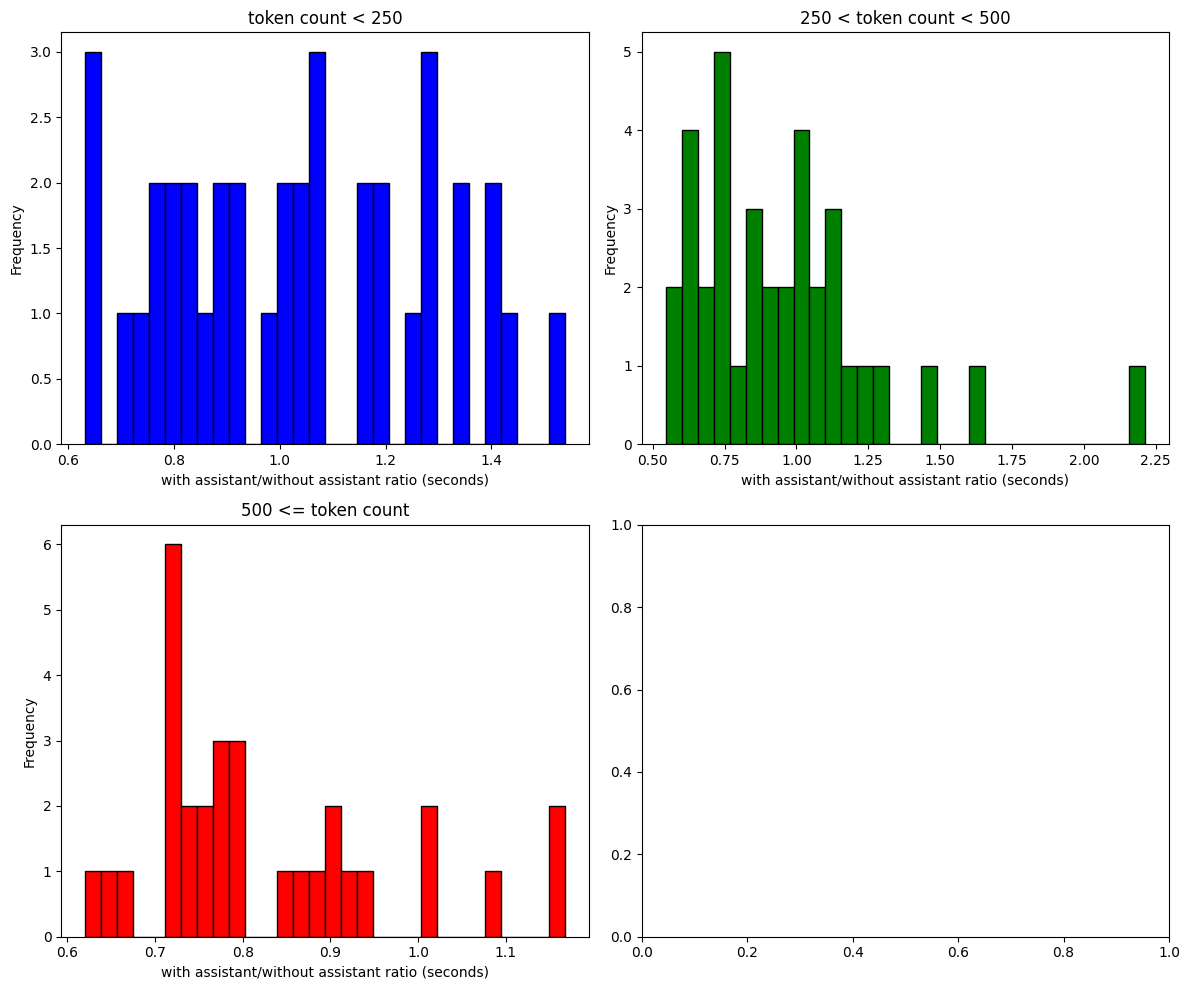

Average speedup ratio:  0.9446407658866276
Average time with assistant:  3.221840987354517
Average time without assistant:  3.7743031448551587
Average time with assistant (over 500 tkns) 4.637663866062799
Average time without assistant (over 500 tkns) 5.656948017437132
Average speedup ratio (over 500 tkns):  0.8280709542034026


 12%|████████                                                         | 13/105 [01:53<16:47, 10.95s/it]

With assistant time > w/o assistant 1.6437718030065298 1.6043082438409328


 16%|██████████▌                                                      | 17/105 [02:34<15:34, 10.62s/it]

With assistant time > w/o assistant 3.017064444720745 3.017014231532812


 19%|████████████▍                                                    | 20/105 [02:51<10:17,  7.27s/it]

With assistant time > w/o assistant 2.744833944365382 2.367879992350936


 24%|███████████████▍                                                 | 25/105 [03:43<11:01,  8.26s/it]

With assistant time > w/o assistant 0.9051555190235376 0.7444140873849392


 26%|████████████████▋                                                | 27/105 [03:57<10:04,  7.75s/it]

With assistant time > w/o assistant 4.2424012478441 4.135091604664922


 28%|█████████████████▉                                               | 29/105 [04:10<08:53,  7.02s/it]

With assistant time > w/o assistant 3.0619954615831375 2.4488610681146383


 33%|█████████████████████▋                                           | 35/105 [04:42<06:36,  5.66s/it]

With assistant time > w/o assistant 1.9258011784404516 1.2242801114916801


 36%|███████████████████████▌                                         | 38/105 [05:01<06:43,  6.02s/it]

With assistant time > w/o assistant 2.1778193432837725 2.0900238920003176


 37%|████████████████████████▏                                        | 39/105 [05:03<05:12,  4.74s/it]

With assistant time > w/o assistant 0.9532075952738523 0.796192679554224


 38%|████████████████████████▊                                        | 40/105 [05:04<03:57,  3.66s/it]

With assistant time > w/o assistant 0.6276185177266598 0.49885707907378674


 48%|██████████████████████████████▉                                  | 50/105 [06:35<04:53,  5.34s/it]

With assistant time > w/o assistant 0.7388211563229561 0.6379018165171146


 50%|████████████████████████████████▊                                | 53/105 [07:18<08:55, 10.30s/it]

With assistant time > w/o assistant 3.4666742626577616 1.7108704596757889


 51%|█████████████████████████████████▍                               | 54/105 [07:24<07:26,  8.76s/it]

With assistant time > w/o assistant 2.6396217979490757 2.5475140530616045


 54%|███████████████████████████████████▎                             | 57/105 [07:45<06:04,  7.60s/it]

With assistant time > w/o assistant 3.5367910489439964 3.1489151287823915


 58%|█████████████████████████████████████▊                           | 61/105 [08:16<04:41,  6.40s/it]

With assistant time > w/o assistant 0.7849013432860374 0.4751034826040268


 60%|███████████████████████████████████████                          | 63/105 [08:19<02:41,  3.84s/it]

With assistant time > w/o assistant 0.9459774680435658 0.6186126135289669


 61%|███████████████████████████████████████▌                         | 64/105 [08:22<02:23,  3.51s/it]

With assistant time > w/o assistant 1.6917500291019678 1.0279072374105453


 65%|██████████████████████████████████████████                       | 68/105 [08:46<03:34,  5.79s/it]

With assistant time > w/o assistant 2.802303597331047 2.5356645863503218


 66%|██████████████████████████████████████████▋                      | 69/105 [08:48<02:43,  4.53s/it]

With assistant time > w/o assistant 0.8297909274697304 0.7679842412471771


 70%|█████████████████████████████████████████████▊                   | 74/105 [09:11<02:10,  4.19s/it]

With assistant time > w/o assistant 0.8336299266666174 0.6204445045441389


 71%|██████████████████████████████████████████████▍                  | 75/105 [09:13<01:43,  3.47s/it]

With assistant time > w/o assistant 0.9191379956901073 0.8405514676123857


 72%|███████████████████████████████████████████████                  | 76/105 [09:14<01:20,  2.78s/it]

With assistant time > w/o assistant 0.6639213915914297 0.530899565666914


 73%|███████████████████████████████████████████████▋                 | 77/105 [09:16<01:06,  2.37s/it]

With assistant time > w/o assistant 0.7784722540527582 0.616170134395361


 74%|████████████████████████████████████████████████▎                | 78/105 [09:17<00:53,  1.99s/it]

With assistant time > w/o assistant 0.672242846339941 0.42554884776473045


 88%|████████████████████████████████████████████████████████▉        | 92/105 [11:20<01:47,  8.26s/it]

With assistant time > w/o assistant 5.569426704198122 4.901403468102217


 89%|█████████████████████████████████████████████████████████▌       | 93/105 [11:26<01:29,  7.47s/it]

With assistant time > w/o assistant 2.9534144569188356 2.65829885751009


 92%|████████████████████████████████████████████████████████████     | 97/105 [12:27<02:11, 16.46s/it]

With assistant time > w/o assistant 18.341368382796645 16.812054187059402


 94%|█████████████████████████████████████████████████████████████▎   | 99/105 [12:45<01:14, 12.40s/it]

With assistant time > w/o assistant 3.208907088264823 3.11340918391943


 95%|████████████████████████████████████████████████████████████▉   | 100/105 [12:49<00:49,  9.89s/it]

With assistant time > w/o assistant 2.1172116342931986 1.894467156380415


 98%|██████████████████████████████████████████████████████████████▊ | 103/105 [13:14<00:17,  8.71s/it]

With assistant time > w/o assistant 4.611377080902457 4.4316436517983675


 99%|███████████████████████████████████████████████████████████████▍| 104/105 [13:16<00:06,  6.81s/it]

With assistant time > w/o assistant 1.2367726098746061 1.1421847753226757


100%|████████████████████████████████████████████████████████████████| 105/105 [13:19<00:00,  7.61s/it]

With assistant time > w/o assistant 1.469444775953889 1.3200327642261982
Analysis for lookup tokens:  80


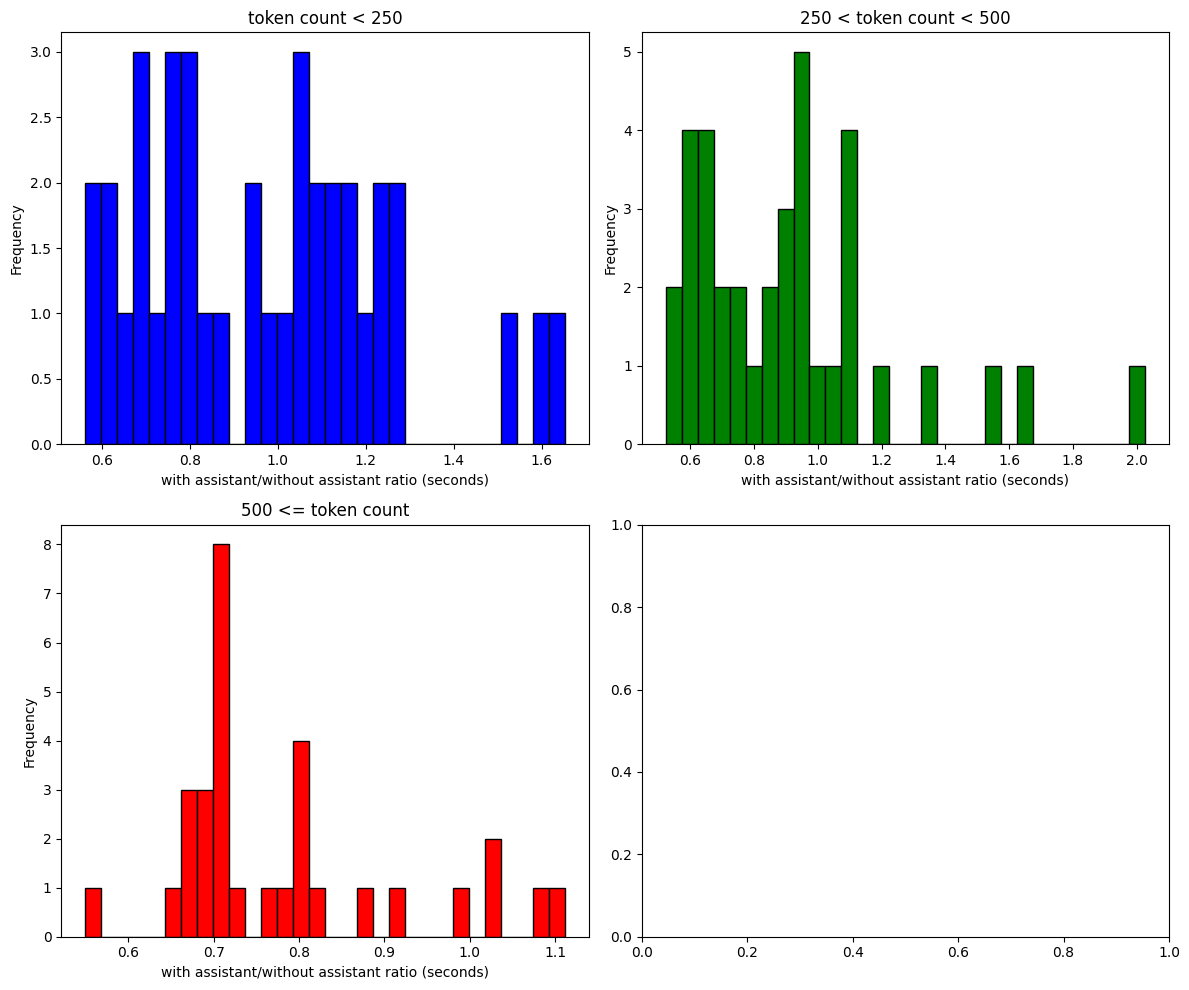

Average speedup ratio:  0.8980806046613387
Average time with assistant:  3.3757080599488245
Average time without assistant:  4.234017959077444
Average time with assistant (over 500 tkns) 4.868194275325345
Average time without assistant (over 500 tkns) 6.324954958452333
Average speedup ratio (over 500 tkns):  0.7834381996470118


 12%|████████                                                         | 13/105 [02:23<20:59, 13.69s/it]

With assistant time > w/o assistant 1.7127225436270237 1.641430888324976


 19%|████████████▍                                                    | 20/105 [03:32<12:11,  8.61s/it]

With assistant time > w/o assistant 2.989747915416956 2.9883498679846525


 24%|███████████████▍                                                 | 25/105 [04:34<13:25, 10.07s/it]

With assistant time > w/o assistant 0.9263900630176067 0.834978761151433


 33%|█████████████████████▋                                           | 35/105 [05:47<08:05,  6.94s/it]

With assistant time > w/o assistant 2.4287797436118126 1.3001556787639856


 37%|████████████████████████▏                                        | 39/105 [06:14<06:36,  6.01s/it]

With assistant time > w/o assistant 1.3498078156262636 1.1023339238017797


 38%|████████████████████████▊                                        | 40/105 [06:15<04:57,  4.58s/it]

With assistant time > w/o assistant 0.733556654304266 0.49474268965423107


 48%|██████████████████████████████▉                                  | 50/105 [08:04<05:46,  6.31s/it]

With assistant time > w/o assistant 0.76673149690032 0.6661817263811827


 50%|████████████████████████████████▊                                | 53/105 [09:00<11:10, 12.89s/it]

With assistant time > w/o assistant 3.8675238750874996 2.463969647884369


 58%|█████████████████████████████████████▊                           | 61/105 [10:07<05:27,  7.45s/it]

With assistant time > w/o assistant 0.9420977085828781 0.47993925027549267


 60%|███████████████████████████████████████                          | 63/105 [10:10<03:04,  4.38s/it]

With assistant time > w/o assistant 0.9846720602363348 0.7465362288057804


 61%|███████████████████████████████████████▌                         | 64/105 [10:13<02:41,  3.95s/it]

With assistant time > w/o assistant 1.6450647972524166 1.287067223340273


 66%|██████████████████████████████████████████▋                      | 69/105 [10:44<03:11,  5.32s/it]

With assistant time > w/o assistant 0.8548334036022425 0.7832069117575884


 70%|█████████████████████████████████████████████▊                   | 74/105 [11:11<02:32,  4.91s/it]

With assistant time > w/o assistant 0.8893394730985165 0.6398769058287144


 71%|██████████████████████████████████████████████▍                  | 75/105 [11:13<02:01,  4.05s/it]

With assistant time > w/o assistant 1.0411530528217554 1.0102919787168503


 72%|███████████████████████████████████████████████                  | 76/105 [11:14<01:34,  3.26s/it]

With assistant time > w/o assistant 0.8026230745017529 0.6134237926453352


 73%|███████████████████████████████████████████████▋                 | 77/105 [11:16<01:16,  2.72s/it]

With assistant time > w/o assistant 0.7855629771947861 0.6461161337792873


 74%|████████████████████████████████████████████████▎                | 78/105 [11:17<01:02,  2.31s/it]

With assistant time > w/o assistant 0.8550924677401781 0.49825938791036606


 99%|███████████████████████████████████████████████████████████████▍| 104/105 [16:06<00:08,  8.12s/it]

With assistant time > w/o assistant 1.438353706151247 1.4124949723482132


100%|████████████████████████████████████████████████████████████████| 105/105 [16:09<00:00,  9.23s/it]

With assistant time > w/o assistant 1.5797538105398417 1.5301174260675907
Analysis for lookup tokens:  160


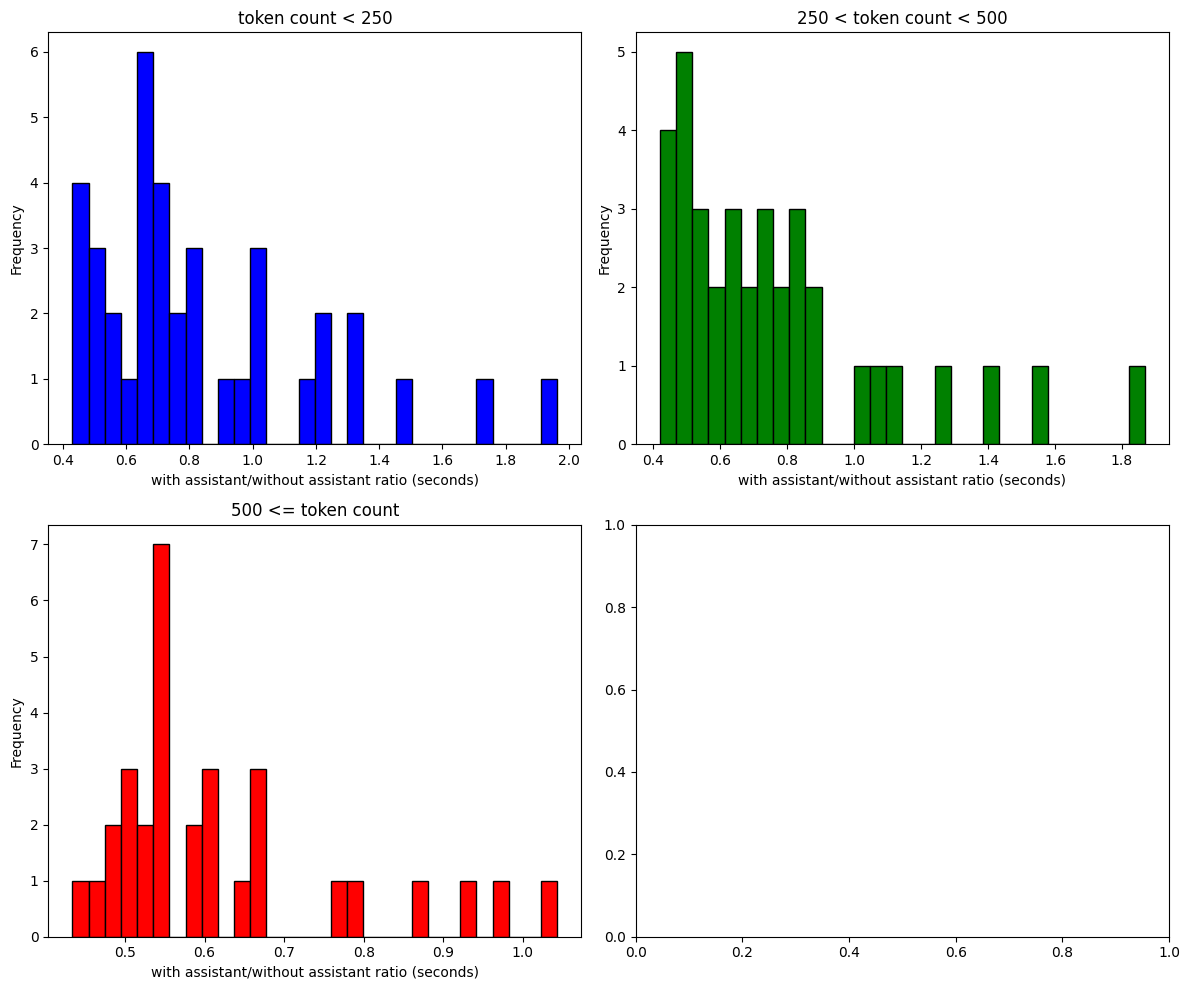

Average speedup ratio:  0.7537112414841244
Average time with assistant:  3.534969517198347
Average time without assistant:  5.690973157772706
Average time with assistant (over 500 tkns) 4.982863972203866
Average time without assistant (over 500 tkns) 8.441260486300434
Average speedup ratio (over 500 tkns):  0.6226827990626449


In [23]:
lookup_tokens = [40, 80, 160]
time_taken = {x: {"with_assistant": [], "without_assistant": []} for x in lookup_tokens}
outputs = {x: {"with_assistant": [], "without_assistant": []} for x in lookup_tokens}
for lt in lookup_tokens:
    for row in tqdm(ds):
        input_text = "## Code Before:\n{code_text}\n## Instruction: {question}\n## Code After:\n".format(code_text=row['before'], question=row['instruction_descriptive'])
        inputs = tokenizer(input_text, return_tensors="pt")
        for key in inputs:
            inputs[key] = inputs[key].to(model.device)
        code_ids = tokenizer(row['before'], return_tensors="pt").input_ids[0].tolist()
            
        max_new_tokens = inputs['input_ids'].shape[-1] + 300
    
        start_time = time.perf_counter()
        test_out = model.greedy_search_assistant_pld(inputs.input_ids,
                        code_ids,
                        draft_model,
                      attention_mask = inputs.attention_mask,
                      stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                    assistant_prompt_matching_window_size = 3,
                    assistant_prompt_candidate_tokens = lt,
                    assistant_draft_candidate_rounds = 6,
                    max_draft_num_candidate_tokens = 1000,
                      use_cache=True, 
                      pad_token_id=tokenizer.pad_token_id,
                      eos_token_id=tokenizer.eos_token_id,
                    print_output=False,
                    seed=10
                )
        end_time = time.perf_counter()
    
        time_taken[lt]["with_assistant"].append(end_time - start_time)
        outputs[lt]["with_assistant"].append(tokenizer.batch_decode(test_out))
    
        start_time = time.perf_counter()
        test_out = model.greedy_search_pld(inputs.input_ids,
                        code_ids,
                      attention_mask = inputs.attention_mask,
                      stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                    draft_matching_window_size = 3,
                    draft_num_candidate_tokens = lt,
                      use_cache=True, 
                      pad_token_id=tokenizer.pad_token_id,
                      eos_token_id=tokenizer.eos_token_id,
                     print_output=False,
                    seed=10
                )
        end_time = time.perf_counter()
        
        time_taken[lt]["without_assistant"].append(end_time - start_time)
        outputs[lt]["without_assistant"].append(tokenizer.batch_decode(test_out))

        if time_taken[lt]["with_assistant"][-1] > time_taken[lt]["without_assistant"][-1]:
            print("With assistant time > w/o assistant", time_taken[lt]["with_assistant"][-1], time_taken[lt]["without_assistant"][-1])
    print("Analysis for lookup tokens: ", lt)
    show_token_split_graphs(time_taken[lt], token_count)

Without assistant :  2.6882898807525635  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.2129423450678587  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  3.4512370880693197  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.2293079644441605  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  1.8643624652177095  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  0.7561845481395721  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  0.4744558911770582  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  0.5692018680274487  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.279698971658945  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Wi

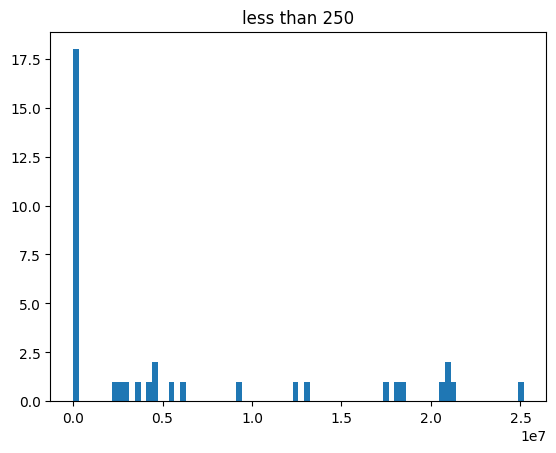

Without assistant :  2.363664770498872  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  0.7243961188942194  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  3.5699053928256035  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.673745969310403  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  1.2034812718629837  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  1.5045891795307398  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.803087703883648  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  0.9134622849524021  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.2646488081663847  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
With

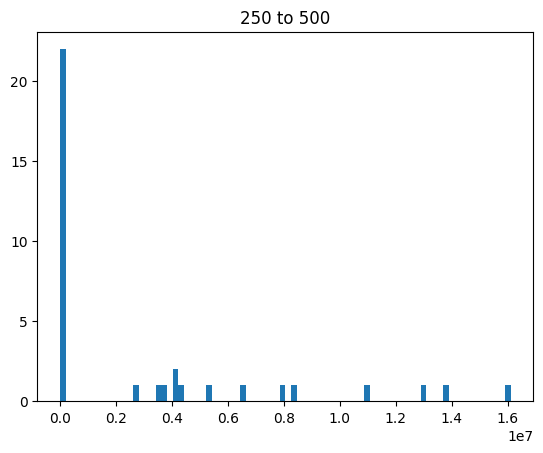

Without assistant :  2.4415740445256233  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.4419486317783594  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  14.793533474206924  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater


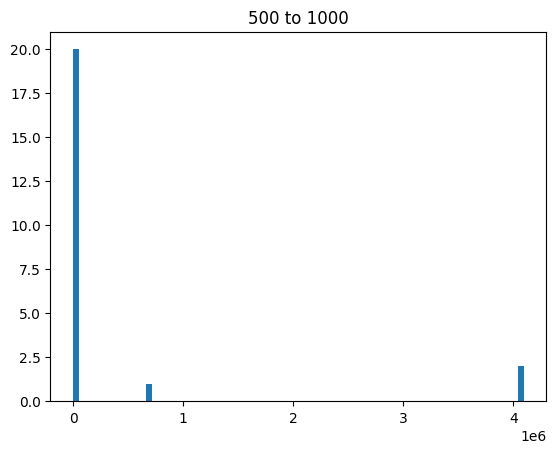

Without assistant :  1.5191578771919012  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater
Without assistant :  2.697912000119686  lookup val:  40  With assistant:  10000000  lookup val:  0 <- greater


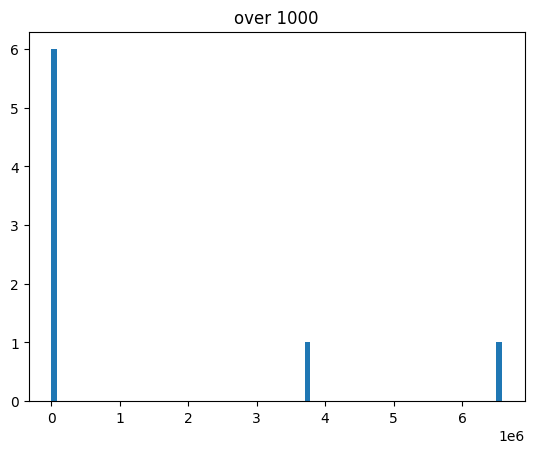

In [24]:
# Find the optimal for each
import numpy as np
import matplotlib.pyplot as plt

z = np.array(token_count)  
r = np.array(list(range(len(z))))
subsets = [r[z < 250], r[(z >= 250) & (z < 500)], r[(z >= 500) & (z < 1000)], r[z >= 1000]]
ssnames  = ["less than 250", "250 to 500", "500 to 1000", "over 1000"]
for ssname, subset in zip(ssnames, subsets):

    sratio = []

    for idx in subset:
        # print(idx)
        best_without_assistant = 1000000
        best_with_assistant = 10000000
    
        best_lookup_without_assistant = 0
        best_lookup_with_assistant = 0

        for lt in lookup_tokens:
            if time_taken[lt]["without_assistant"][idx] < best_without_assistant:
                best_without_assistant = time_taken[lt]["without_assistant"][idx]
                best_lookup_without_assistant = lt
            if time_taken[lt]["with_assistant"][idx] < best_without_assistant:
                best_with_assistant = time_taken[lt]["with_assistant"][idx]
                best_lookup_with_assistant = lt

    
        sratio.append(best_with_assistant/best_without_assistant)
        if sratio[-1] > 1:
            print("Without assistant : ", best_without_assistant, " lookup val: ",  best_lookup_without_assistant, " With assistant: ", best_with_assistant," lookup val: ", best_lookup_with_assistant, "<- greater" if best_with_assistant/best_without_assistant > 1 else "")
    plt.title(ssname)
    plt.hist(sratio, bins=80)
    plt.show()

In [25]:
# sum(time_taken['with_assistant'])

In [26]:
# sum(time_taken['without_assistant'])

In [27]:
ratios = []
assisted_sum = 0
non_assisted_sum = 0
for idx, (i, j) in enumerate(zip(time_taken['with_assistant'], time_taken['without_assistant'])):
    ratios.append(i / j)
    if i / j > 1:
        print(outputs['with_assistant'][idx][0])
        if not(outputs['with_assistant'][idx][0] == outputs['without_assistant'][idx][0]):
            print("ERROR - with assistant and without assistant have different results. Without assistant:\n")
            print(outputs["without_assistant"][idx][0])
        print("============")
    else:
        assisted_sum += i
        non_assisted_sum += j
print(ratios)

KeyError: 'with_assistant'

In [ ]:
import difflib

count = 0
for wa, woa in zip(outputs['with_assistant'], outputs['without_assistant']):
    if not(wa[0] == woa[0]):
        count += 1
        print("Discrepancy: ")
        print("\n".join(difflib.unified_diff(woa[0].splitlines(), wa[0].splitlines())))

print(count)

In [ ]:
print(assisted_sum, non_assisted_sum, assisted_sum/non_assisted_sum)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ratios, bins=80)
plt.show()

In [ ]:
show_token_split_graphs(time_taken, token_count)

In [ ]:
# Create scatter plots
plt.scatter(token_count, time_taken[80]["with_assistant"], color='blue', label='w/ assistant')
plt.scatter(token_count, time_taken[80]["without_assistant"], color='red', label='no assistant')

# Add title and labels
plt.title('Scatter Plot')
plt.xlabel('Code tokens')
plt.ylabel('Time taken')

# Add legend
plt.legend()
plt.show()